### Guided Project Predicting Bike Rentals

##### sorelle saperia

In [ ]:
June 2021

we will look at a dataset of entries for bikes rented out and try to create a model to predict number of bikes people rented in a given hour. the dataset has diff info for that hr incl the temperature month year and season etc

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline
np.random.seed(42)

In [2]:
bike_rentals=pd.read_csv('bike rentals.csv')

In [3]:
#veiwing data
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
bike_rentals.shape

(17379, 17)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C381945B20>]],
      dtype=object)

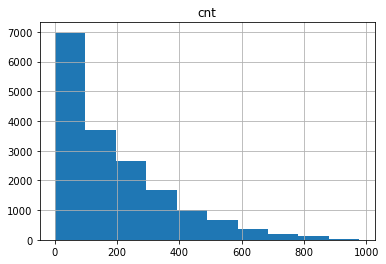

In [6]:
#viewing the values for the cnt column
bike_rentals.hist('cnt')

we see the distribution here most of values fall at lower no. of bike_rentals gradually getting less as get to higher counts. a bit weighted to the lower side

In [7]:
#look at correlation between 'cnt' and the other columns to see which ones should be used as features for our model
bike_rentals.corr()[['cnt']]

,cnt
instant,0.278379
season,0.178056
yr,0.250495
mnth,0.120638
hr,0.394071
holiday,-0.030927
weekday,0.026900
workingday,0.030284
weathersit,-0.142426
temp,0.404772


In [8]:
corr=bike_rentals.corr()

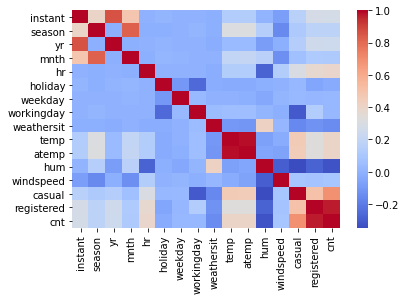

In [9]:
import seaborn as sns
sns.heatmap(corr, cmap='coolwarm')

columns 'temp' and 'atemp' have high corr with cnt, so are good features however they correlate too strongly with each other and therefore are too similar (one is based off the other) so will just use one will choose temp as it correlates very slightly better with cnt than atemp which means it may be a better feature. 'hr' correlates with cnt quite well so will use this. 'hum' which is humidity correlates next strongly and negatively with cnt so want to use it. hum correlates around  .3 negatively with hr it's not high enough to leave one of them out for the moment but is interesting to note. yr is the next highest correlation so would like to experiment with it if need more features. so for the moment choosing features temp, hr, hum, yr

In [10]:
#changing hr to time label as sections of the day as one hr to the next is not significantly diff
def assign_label(val):
    if (val>=6) & (val<12):
        return 1
    elif (val>=12) & (val<18):
        return 2
    elif (val>=18) & (val<24):
        return 3
    elif (val>=0) and (val<6):
        return 4
    
bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)  

In [11]:
#see values for time label
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

now going to look at the cnt values as this will be target column

In [12]:
bike_rentals['cnt'].value_counts()

5      260
6      236
4      231
3      224
2      208
      ... 
725      1
709      1
661      1
629      1
887      1
Name: cnt, Length: 869, dtype: int64

the target column is continuous so we will need a linear regression type of model

In [13]:
#splitting data into train and test sets
X=bike_rentals[['temp','time_label','hum','yr']]
y=bike_rentals['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Linear Regression

In [14]:
#basic linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
train_predictions=lr.predict(X_train)
test_predictions=lr.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
print(train_rmse,test_rmse)

140.8300058551144 140.6027185473735


yr seems to give better result so including that column

trying same model with more features see if better model, season and month corr slightly with cnt so using season not trying both as corr too well with each other

In [15]:
X=bike_rentals[['time_label','temp','hum','yr','season']]
y=bike_rentals['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
train_predictions=lr.predict(X_train)
test_predictions=lr.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
print(train_rmse,test_rmse)

138.988666292349 140.13082330599167


this was a better model as rmse is lower we see it's not overfit as test and train predictions are similar

#### Decision Tree

In [17]:
#now using decision tree regressor model
dt=DecisionTreeRegressor()
dt.fit(X_train,y_train)
train_predictions=dt.predict(X_train)
test_predictions=dt.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
print(train_rmse,test_rmse)

81.00990290510207 145.03445898170565


decision trees generally overfit we see this as rmse for train set is way lower than test set we need to prune the tree to make it less overfit

In [18]:
#trying out this model with diff min sample leaf and max depth
train_scores=[]
test_scores=[]
for i in  range(1,15):
    dt=DecisionTreeRegressor(min_samples_leaf=7,max_depth=i)
    dt.fit(X_train,y_train)
    train_predictions=dt.predict(X_train)
    test_predictions=dt.predict(X_test)
    train_mse=mean_squared_error(y_train,train_predictions)
    test_mse=mean_squared_error(y_test,test_predictions)
    train_rmse=np.sqrt(train_mse)
    test_rmse=np.sqrt(test_mse)
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)
    print(i,train_rmse,test_rmse)

1 154.7337184733521 156.2945816051303
2 142.84741742655558 143.40974025615645
3 133.63052681308733 134.21410546244755
4 127.6582746871275 127.76880569147535
5 123.94946315768819 124.11160136319536
6 121.92506001115362 123.47764269384882
7 120.07173743667308 122.29757157886961
8 118.11549953142392 121.51649333300132
9 116.05046347463386 121.63780689297519
10 113.94975092623112 121.90234425010102
11 111.96620281034235 123.07130140773165
12 110.02718083442556 123.48604940560229
13 108.87861150184256 124.58658629204638
14 107.91905915382846 125.2290171903446


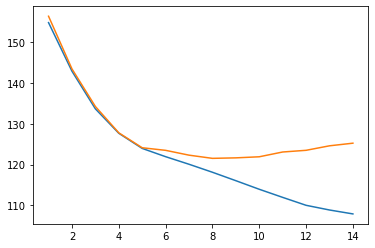

In [19]:
plt.plot(range(1, 15), train_scores, label='train')
plt.plot(range(1, 15), test_scores, label='test')
plt.show()

changed the diff parameters found that min_samples_leaf=7 was very good and max depth at 7 was best at this without the train and test predictions being too diff we see that the rmse for train set and test set diverge strongly at around 7 so good value.

#### Random Forest

In [20]:
#basic random forest regressor model
rf=RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())
train_predictions=rf.predict(X_train)

test_predictions=rf.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
print(train_rmse,test_rmse)


85.07379537497759 130.18074492251282


the rmse values are too diff this model is very overfit

In [21]:
#looking at what the change in number of trees in this model is doing
for i in range(10,100,10):
        rf=RandomForestRegressor(n_estimators=i)
        rf.fit(X_train, y_train.values.ravel())
        train_predictions=rf.predict(X_train)

        test_predictions=rf.predict(X_test)
        train_mse=mean_squared_error(y_train,train_predictions)
        test_mse=mean_squared_error(y_test,test_predictions)
        train_rmse=np.sqrt(train_mse)
        test_rmse=np.sqrt(test_mse)
        print('trees:',i,train_rmse,test_rmse)

trees: 10 88.0814377262635 132.30853537247322
trees: 20 86.03014528075502 131.14174342388716
trees: 30 85.79606615342172 130.74692287036297
trees: 40 85.57389375522318 130.15396036307158
trees: 50 85.46335568397879 130.00266772403737
trees: 60 85.33758707984147 129.92734981114188
trees: 70 85.27545161452798 130.0352361214927
trees: 80 85.11068642297951 130.157037476606
trees: 90 85.08684582674708 130.39692703363875


In [22]:
#choosing 30 trees as more trees is not making too much diff here unless use very few trees which may be not good will play with other parameters to tweak it now

In [65]:
#for a range of max depths looking at the rmse for the model
train_scores=[]
test_scores=[]
for e in range(1,17):
        rf=RandomForestRegressor(n_estimators=30,max_depth=e)
        rf.fit(X_train, y_train.values.ravel())
        train_predictions=rf.predict(X_train)

        test_predictions=rf.predict(X_test)
        train_mse=mean_squared_error(y_train,train_predictions)
        test_mse=mean_squared_error(y_test,test_predictions)
        train_rmse=np.sqrt(train_mse)
        test_rmse=np.sqrt(test_mse)
        train_scores.append(train_rmse)
        test_scores.append(test_rmse)
        print(e,train_rmse,test_rmse)

1 154.73394458458793 156.2883665583233
2 141.98046471671216 142.6528581084446
3 132.6367776681174 133.30704266781697
4 125.8554321737535 126.02929606316913
5 122.8115924586435 123.09234375387817
6 120.70506224342603 121.81099710722623
7 118.08142941904667 120.03148123500134
8 115.70490534799798 119.0738944225187
9 112.8432830124474 118.60876037167849
10 109.3906669758753 118.48142185465771
11 105.65805202409548 118.97083532708831
12 101.71309607040368 120.41770952754105
13 97.99164135612689 121.47240576242737
14 94.61981551409269 123.40363556255784
15 91.63163838847149 124.6636640645512
16 89.67773286443419 125.9804805647518


max depth of 7 seems best as after that model seems to get too 'good' for train set compared to test set which is overfitting so using max depth of 7

In [59]:
#min_samples_leaf parameters check out diff values see if improves with the above model
train_scores=[]
test_scores=[]
for e in range(2,400,40):
        rf=RandomForestRegressor(n_estimators=30,max_depth=7,min_samples_leaf=e)
        rf.fit(X_train, y_train.values.ravel())
        train_predictions=rf.predict(X_train)

        test_predictions=rf.predict(X_test)
        train_mse=mean_squared_error(y_train,train_predictions)
        test_mse=mean_squared_error(y_test,test_predictions)
        train_rmse=np.sqrt(train_mse)
        test_rmse=np.sqrt(test_mse)
        train_scores.append(train_rmse)
        test_scores.append(test_rmse)
        print(e,train_rmse,test_rmse)

2 118.24282627971311 119.96801847455518
42 118.8630314558638 120.08443225669829
82 119.80519717598925 120.69714944250643
122 120.68388602634845 121.34488892957476
162 121.46623882196644 121.9296287134494
202 122.07115609947626 122.34167910433254
242 122.78579724490237 122.8209385524979
282 123.71915618278288 123.82067461978991
322 124.18895064694873 124.36860248076783
362 124.87370936902767 125.18267150523899


none of these are much better than the model before so will not use min_sample_leaf

In [60]:
# my best model is so far:
rf=RandomForestRegressor(n_estimators=30,max_depth=7)
rf.fit(X_train, y_train.values.ravel())
train_predictions=rf.predict(X_train)

test_predictions=rf.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
train_scores.append(train_rmse)
test_scores.append(test_rmse)
print(train_rmse,test_rmse)

118.29473489866393 120.1803474999824


the error doesn't seem too far to be overfit and the accuracy seems quite good as has low rmse which means that the error of the predictions is low only about 120 out and the values range from 0 to 1000. I am tweaking it now by trying bagging with bootstrap=true and see what the errors are

In [ ]:
rf=RandomForestRegressor(n_estimators=30,max_depth=7,bootstrap=True)
rf.fit(X_train, y_train.values.ravel())
train_predictions=rf.predict(X_train)

test_predictions=rf.predict(X_test)
train_mse=mean_squared_error(y_train,train_predictions)
test_mse=mean_squared_error(y_test,test_predictions)
train_rmse=np.sqrt(train_mse)
test_rmse=np.sqrt(test_mse)
train_scores.append(train_rmse)
test_scores.append(test_rmse)
print(train_rmse,test_rmse)

went down very slightly with bootstrap

#### XGBoost

In [61]:
#looking at diff max depths
for each in range(1,10):
    model=xgb.XGBRegressor(
            max_depth= each,
            n_estimators=3)
    model.fit(X_train,y_train)
    train_predictions=model.predict(X_train)
    test_predictions=model.predict(X_test)
    train_mse=mean_squared_error(y_train,train_predictions)
    test_mse=mean_squared_error(y_test,test_predictions)
    train_rmse=np.sqrt(train_mse)
    test_rmse=np.sqrt(test_mse)
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)
    print(each,train_rmse,test_rmse)


1 169.03434458476312 171.77188229140674
2 158.0807231910511 160.4445494466238
3 152.03840337992511 154.10331441627523
4 148.3902455964026 150.83527611675441
5 146.18751139399282 148.40793288032458
6 144.59091247948126 147.37981343001934
7 143.12729951907068 146.20559408949464
8 141.86297742545491 145.88917306906646
9 140.46022028285373 145.57607069425666


7 for max depth seems best here so will use that

In [49]:
for each in range(0,100,5):
    model=xgb.XGBRegressor(
            max_depth= 7,
            n_estimators=each)
    model.fit(X_train,y_train)
    train_predictions=model.predict(X_train)
    test_predictions=model.predict(X_test)
    train_mse=mean_squared_error(y_train,train_predictions)
    test_mse=mean_squared_error(y_test,test_predictions)
    train_rmse=np.sqrt(train_mse)
    test_rmse=np.sqrt(test_mse)
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)
    print(each,train_rmse,test_rmse)

0 260.8438844052312 265.15606549331306
5 123.56169048208177 126.79265230624203
10 114.40527883555399 119.00301056106129
15 111.52401908019594 118.53305941970909
20 110.11639047967546 118.60268823993144
25 108.63185957109627 119.08159977742852
30 107.64069663830438 119.34166374621398
35 106.79750726505698 119.55435123374463
40 106.26303928526758 119.69718364512315
45 105.21230113722346 120.01207904698877
50 104.41175163774186 120.19481568068672
55 103.42781012927713 120.46814851566687
60 102.88949810770961 120.48784377564355
65 101.83999234056407 120.97673976714061
70 101.21332470707215 121.21726892234457
75 100.51309873663575 121.56313078841079
80 99.81959081050898 122.05828133922805
85 99.40498255963564 122.40685562973687
90 98.80526653517205 122.50934598069958
95 98.37364040374271 122.79557308455601


i will use 10 trees as that is where the rmses are still somewhat close and also low

In [50]:
#now will change learnign rate see what it does
lr=[.001, .01, .1, .3, .5, .15]
for each in lr:
    model=xgb.XGBRegressor(
            max_depth= 7,
            n_estimators=10,learning_rate=each)
    model.fit(X_train,y_train)
    train_predictions=model.predict(X_train)
    test_predictions=model.predict(X_test)
    train_mse=mean_squared_error(y_train,train_predictions)
    test_mse=mean_squared_error(y_test,test_predictions)
    train_rmse=np.sqrt(train_mse)
    test_rmse=np.sqrt(test_mse)
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)
    print(each,train_rmse,test_rmse)

0.001 258.80849123780126 263.1048777829533
0.01 241.48350898883703 245.63311450249552
0.1 143.63925624584454 146.7813914190665
0.3 114.40527883555399 119.00301056106129
0.5 111.4836190654193 119.17657435331635
0.15 125.95795878884414 129.14475863361125


this didn't seem to help so will leave it as the results from before are better

In [52]:
booster =['gbtree', 'gblinear', 'dart']
for each in booster:
    model=xgb.XGBRegressor(
            max_depth= 7,
            n_estimators=10,booster=each)
    model.fit(X_train,y_train)
    train_predictions=model.predict(X_train)
    test_predictions=model.predict(X_test)
    train_mse=mean_squared_error(y_train,train_predictions)
    test_mse=mean_squared_error(y_test,test_predictions)
    train_rmse=np.sqrt(train_mse)
    test_rmse=np.sqrt(test_mse)
    train_scores.append(train_rmse)
    test_scores.append(test_rmse)
    print(each,train_rmse,test_rmse)

gbtree 114.40527883555399 119.00301056106129
[23:49:41] WARNING: ..\src\learner.cc:541: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


gblinear 148.7207773073152 149.8729361086605
dart 114.40527879996122 119.00301056281741


this didn't make it a better model dart is the same values as before so will not use this parameter

In conclusion we're left with an xgbregressor model that has n_estimators of 10 and a max depth of 7 as the best model so far with the smallest rmses and the gap between the test and train data not being too wide, therefore not being overfit or underfit.